In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

2025-04-27 22:07:13.351224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745791633.605807      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745791633.672508      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
tr_df = train_df('/kaggle/input/soil-types-dataset/Dataset/Train')

In [5]:
tr_df

Class Path          Class
0     /kaggle/input/soil-types-dataset/Dataset/Train...  Alluvial soil
1     /kaggle/input/soil-types-dataset/Dataset/Train...  Alluvial soil
2     /kaggle/input/soil-types-dataset/Dataset/Train...  Alluvial soil
3     /kaggle/input/soil-types-dataset/Dataset/Train...  Alluvial soil
4     /kaggle/input/soil-types-dataset/Dataset/Train...  Alluvial soil
...                                                 ...            ...
1210  /kaggle/input/soil-types-dataset/Dataset/Train...      Clay soil
1211  /kaggle/input/soil-types-dataset/Dataset/Train...      Clay soil
1212  /kaggle/input/soil-types-dataset/Dataset/Train...      Clay soil
1213  /kaggle/input/soil-types-dataset/Dataset/Train...      Clay soil
1214  /kaggle/input/soil-types-dataset/Dataset/Train...      Clay soil

[1215 rows x 2 columns]

In [6]:
ts_df = test_df('/kaggle/input/soil-types-dataset/Dataset/test')

In [7]:
ts_df

Class Path          Class
0    /kaggle/input/soil-types-dataset/Dataset/test/...  Alluvial soil
1    /kaggle/input/soil-types-dataset/Dataset/test/...  Alluvial soil
2    /kaggle/input/soil-types-dataset/Dataset/test/...  Alluvial soil
3    /kaggle/input/soil-types-dataset/Dataset/test/...  Alluvial soil
4    /kaggle/input/soil-types-dataset/Dataset/test/...  Alluvial soil
..                                                 ...            ...
335  /kaggle/input/soil-types-dataset/Dataset/test/...      Clay soil
336  /kaggle/input/soil-types-dataset/Dataset/test/...      Clay soil
337  /kaggle/input/soil-types-dataset/Dataset/test/...      Clay soil
338  /kaggle/input/soil-types-dataset/Dataset/test/...      Clay soil
339  /kaggle/input/soil-types-dataset/Dataset/test/...      Clay soil

[340 rows x 2 columns]

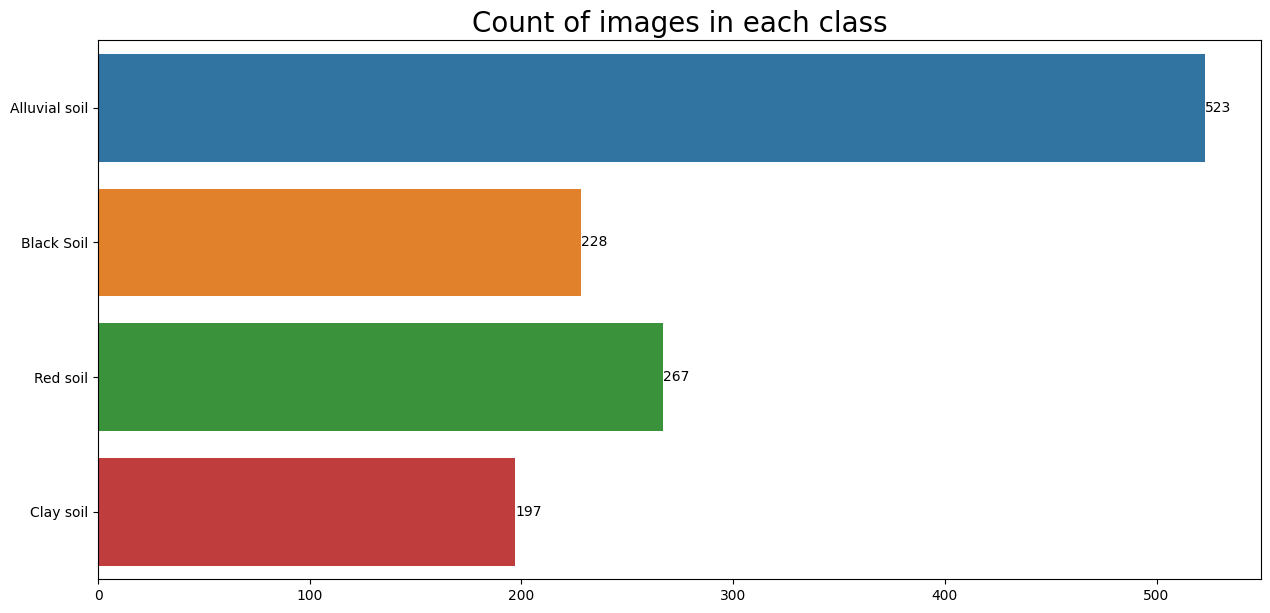

In [8]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

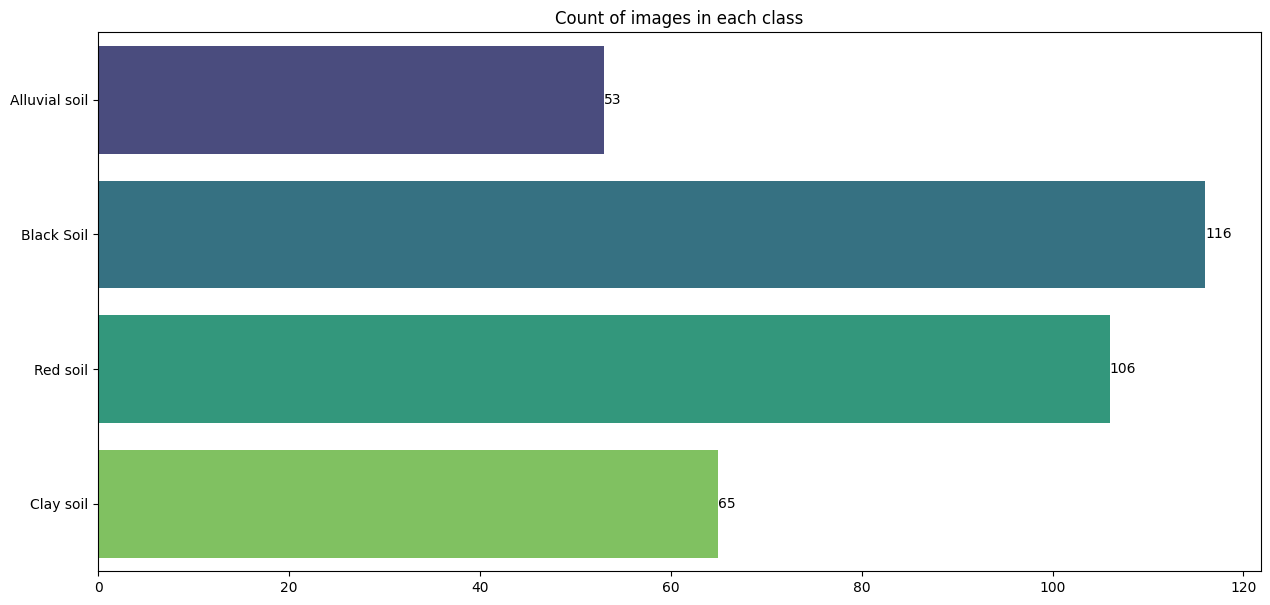

In [9]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [11]:
valid_df

Class Path       Class
136  /kaggle/input/soil-types-dataset/Dataset/test/...  Black Soil
124  /kaggle/input/soil-types-dataset/Dataset/test/...  Black Soil
165  /kaggle/input/soil-types-dataset/Dataset/test/...  Black Soil
198  /kaggle/input/soil-types-dataset/Dataset/test/...    Red soil
164  /kaggle/input/soil-types-dataset/Dataset/test/...  Black Soil
..                                                 ...         ...
110  /kaggle/input/soil-types-dataset/Dataset/test/...  Black Soil
118  /kaggle/input/soil-types-dataset/Dataset/test/...  Black Soil
152  /kaggle/input/soil-types-dataset/Dataset/test/...  Black Soil
146  /kaggle/input/soil-types-dataset/Dataset/test/...  Black Soil
279  /kaggle/input/soil-types-dataset/Dataset/test/...   Clay soil

[170 rows x 2 columns]

In [12]:
ts_df

Class Path          Class
318  /kaggle/input/soil-types-dataset/Dataset/test/...      Clay soil
32   /kaggle/input/soil-types-dataset/Dataset/test/...  Alluvial soil
113  /kaggle/input/soil-types-dataset/Dataset/test/...     Black Soil
38   /kaggle/input/soil-types-dataset/Dataset/test/...  Alluvial soil
325  /kaggle/input/soil-types-dataset/Dataset/test/...      Clay soil
..                                                 ...            ...
296  /kaggle/input/soil-types-dataset/Dataset/test/...      Clay soil
263  /kaggle/input/soil-types-dataset/Dataset/test/...       Red soil
338  /kaggle/input/soil-types-dataset/Dataset/test/...      Clay soil
120  /kaggle/input/soil-types-dataset/Dataset/test/...     Black Soil
109  /kaggle/input/soil-types-dataset/Dataset/test/...     Black Soil

[170 rows x 2 columns]

In [13]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 1215 validated image filenames belonging to 4 classes.
Found 170 validated image filenames belonging to 4 classes.
Found 170 validated image filenames belonging to 4 classes.


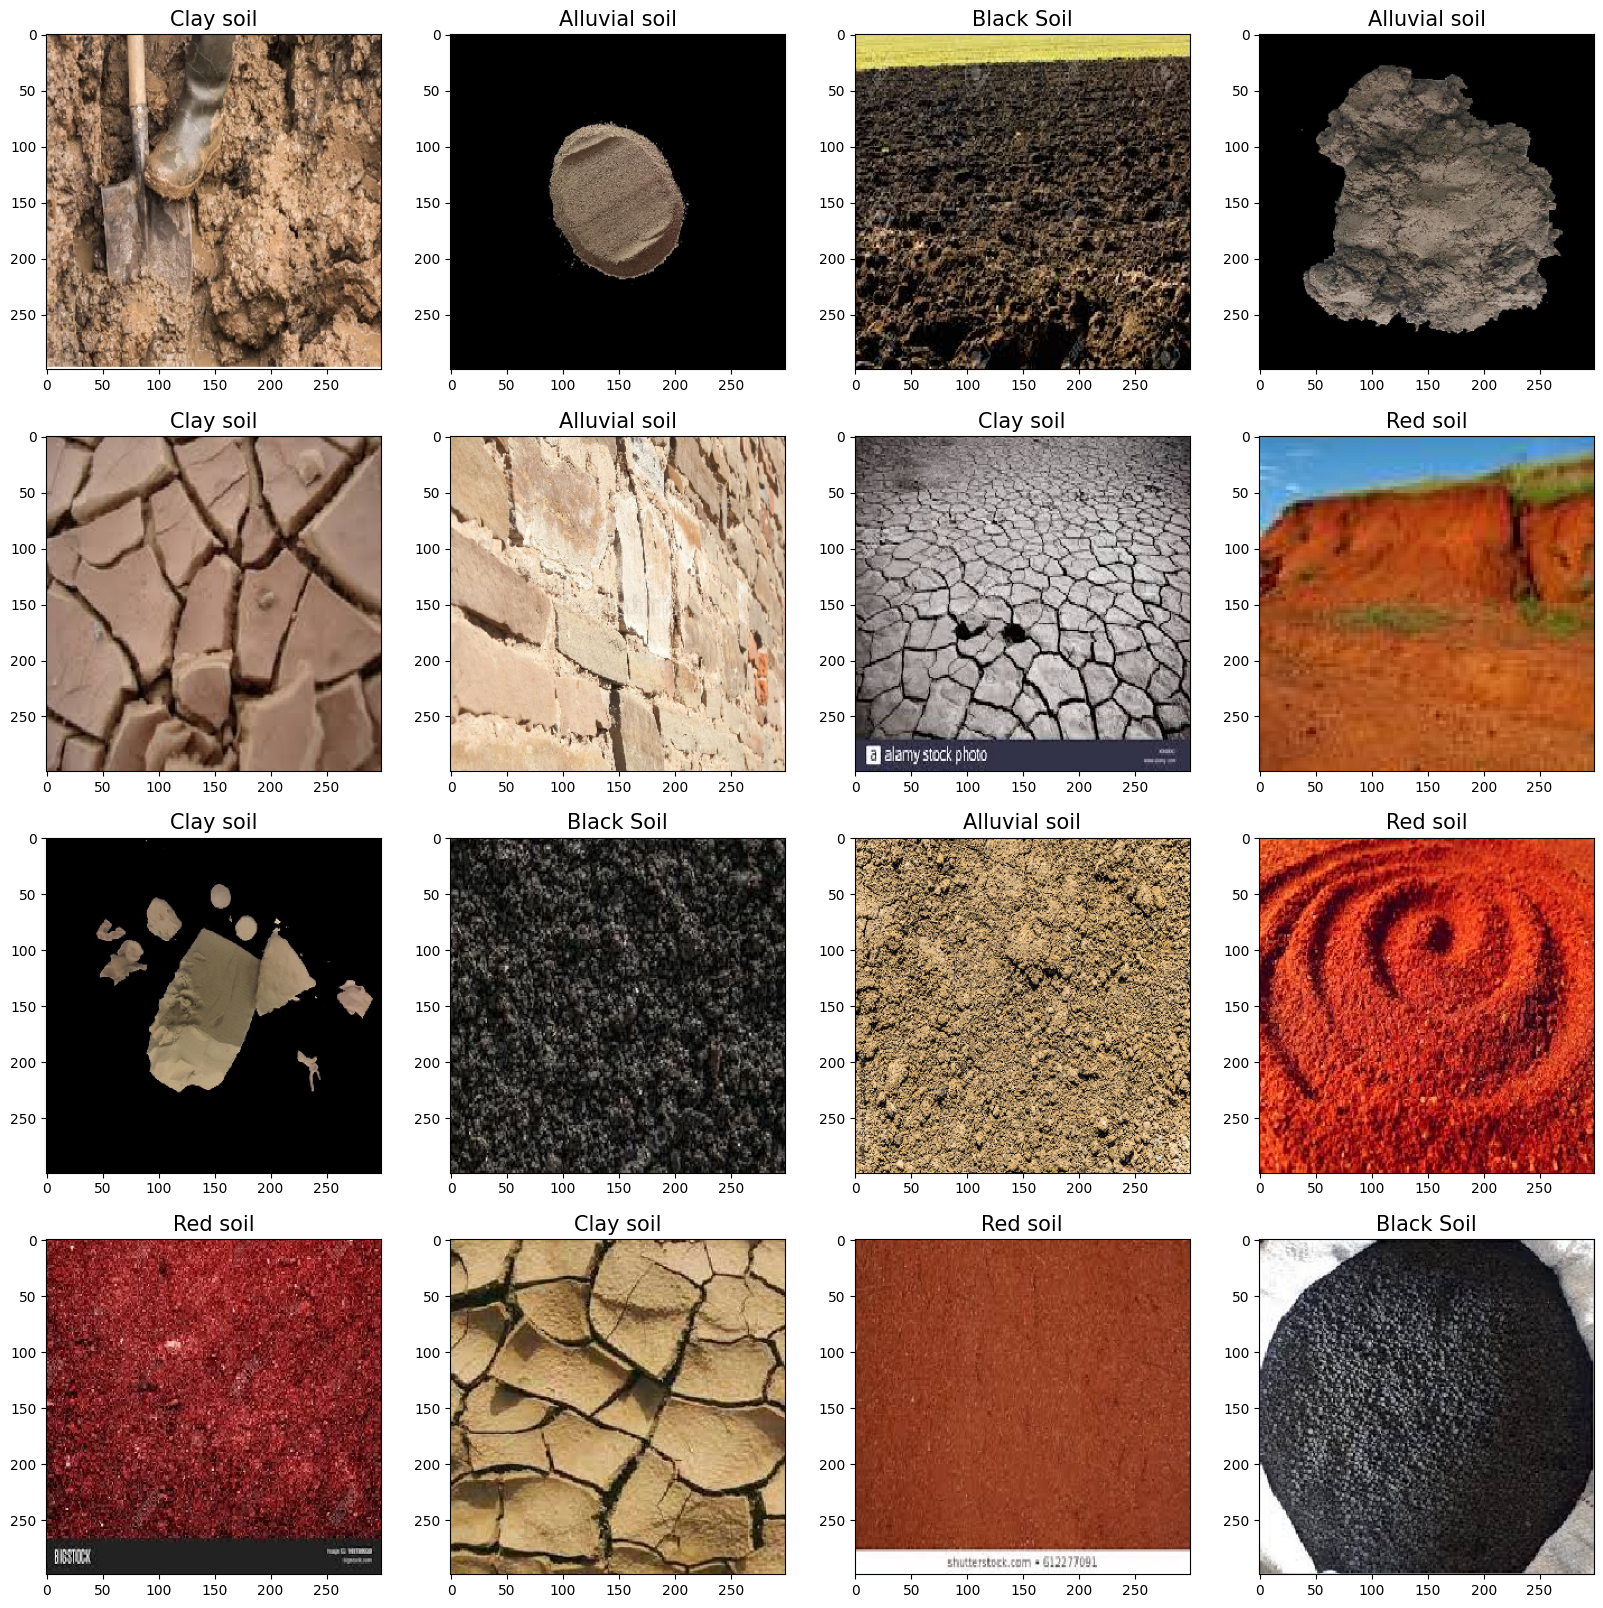

In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

In [15]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.4),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.4),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

I0000 00:00:1745791686.475177      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745791686.475887      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

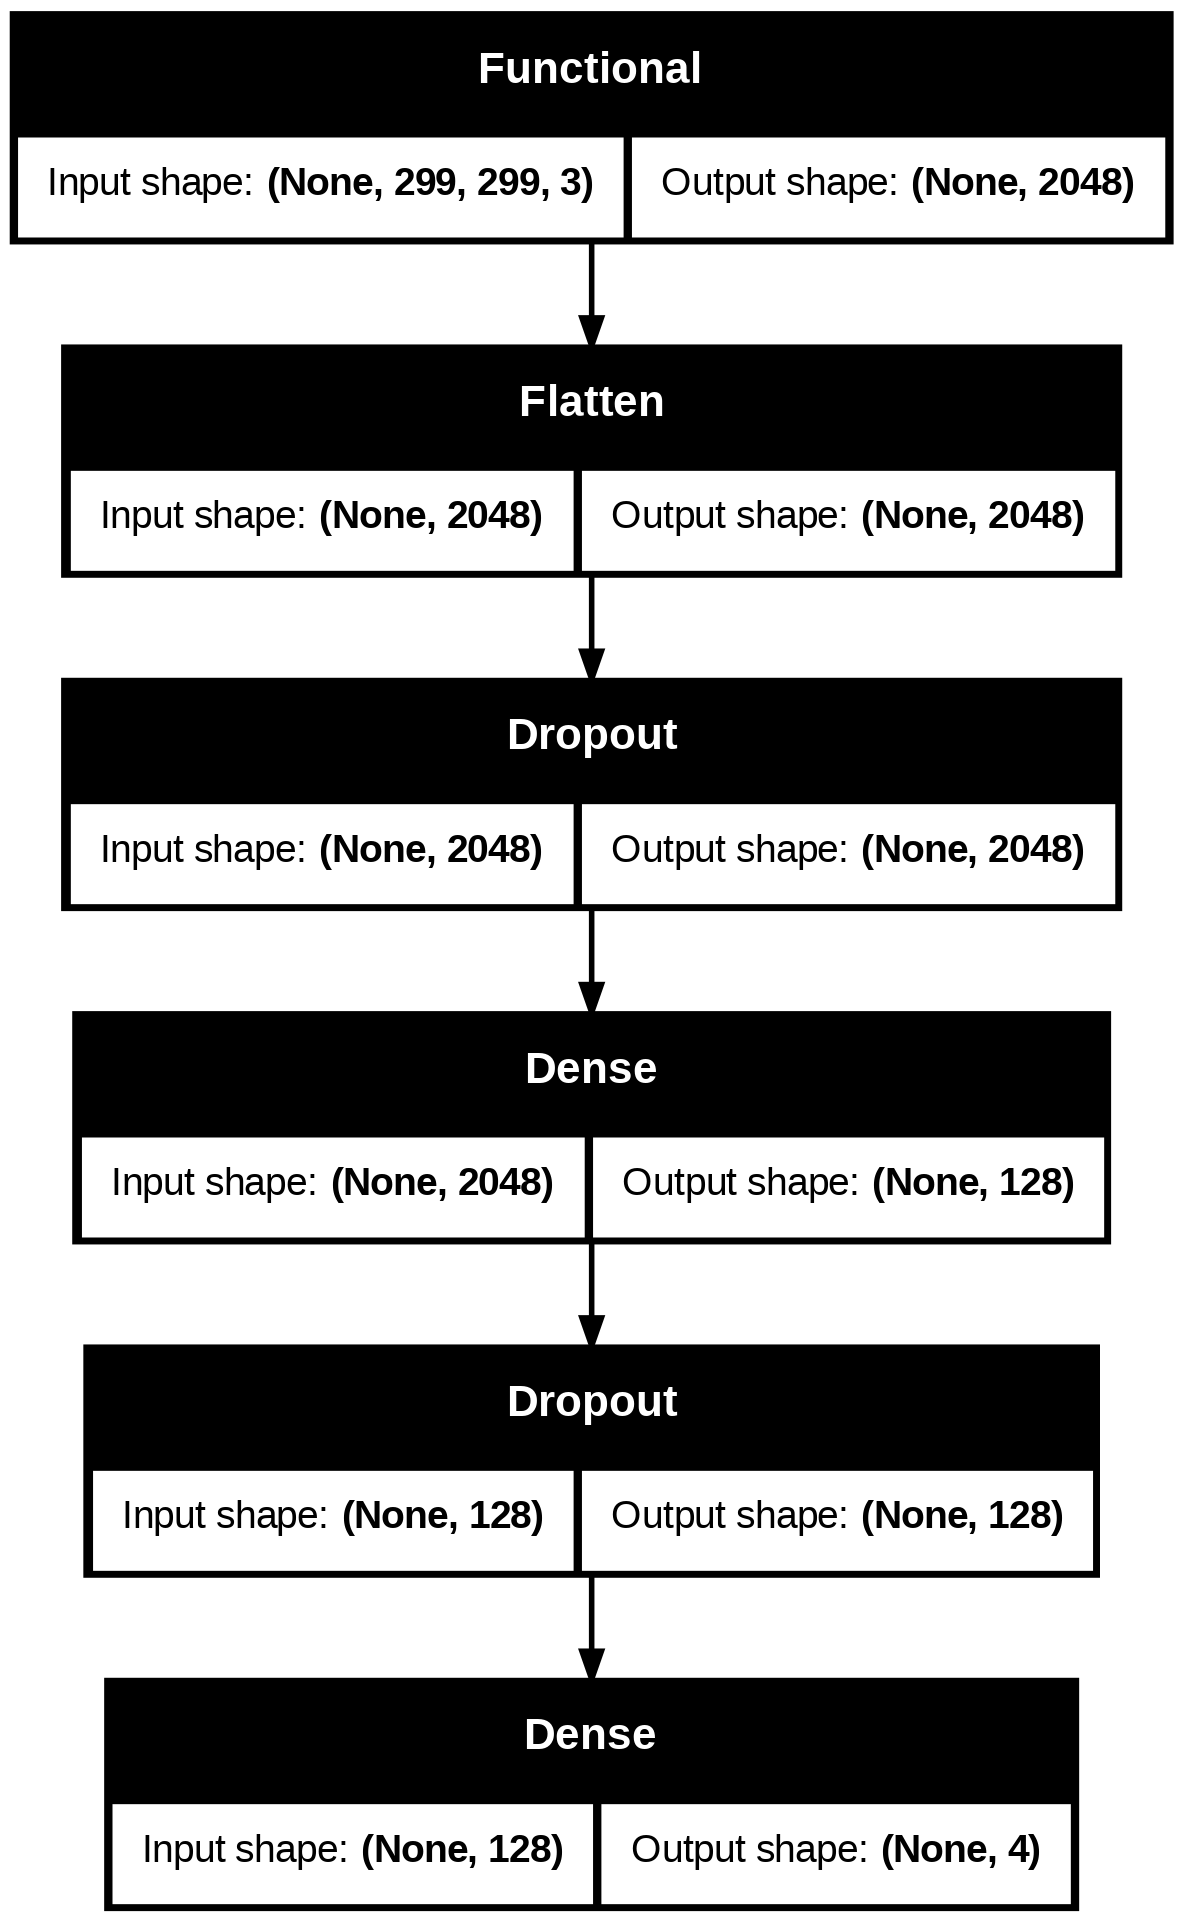

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10


I0000 00:00:1745791730.657364      98 service.cc:148] XLA service 0x7e7914015680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745791730.658503      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745791730.658526      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745791733.358219      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-27 22:09:00.352906: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.6341 - loss: 1.3298 - precision: 0.6798 - recall: 0.4769

E0000 00:00:1745791842.844199      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745791843.135661      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745791846.179116      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745791846.421778      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745791848.404897      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

38/38 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.6410 - loss: 1.2995 - precision: 0.6878 - recall: 0.4865 - val_accuracy: 0.8882 - val_loss: 0.3076 - val_precision: 0.8896 - val_recall: 0.8529
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9141 - loss: 0.2239 - precision: 0.9255 - recall: 0.9071 - val_accuracy: 0.9647 - val_loss: 0.1224 - val_precision: 0.9702 - val_recall: 0.9588
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9806 - loss: 0.0749 - precision: 0.9847 - recall: 0.9767 - val_accuracy: 0.9824 - val_loss: 0.0324 - val_precision: 0.9824 - val_recall: 0.9824
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9824 - loss: 0.0442 - precision: 0.9824 - recall: 0.9820 - val_accuracy: 0.9941 - val_loss: 0.0239 - val_precision: 0.9941 - val_recall: 0.9941
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9885 - loss: 0.0476 - precision: 0.9900 - recall: 0.9883 - val_accuracy: 1.0000 - val_loss: 0.0023 - val_precision

In [18]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

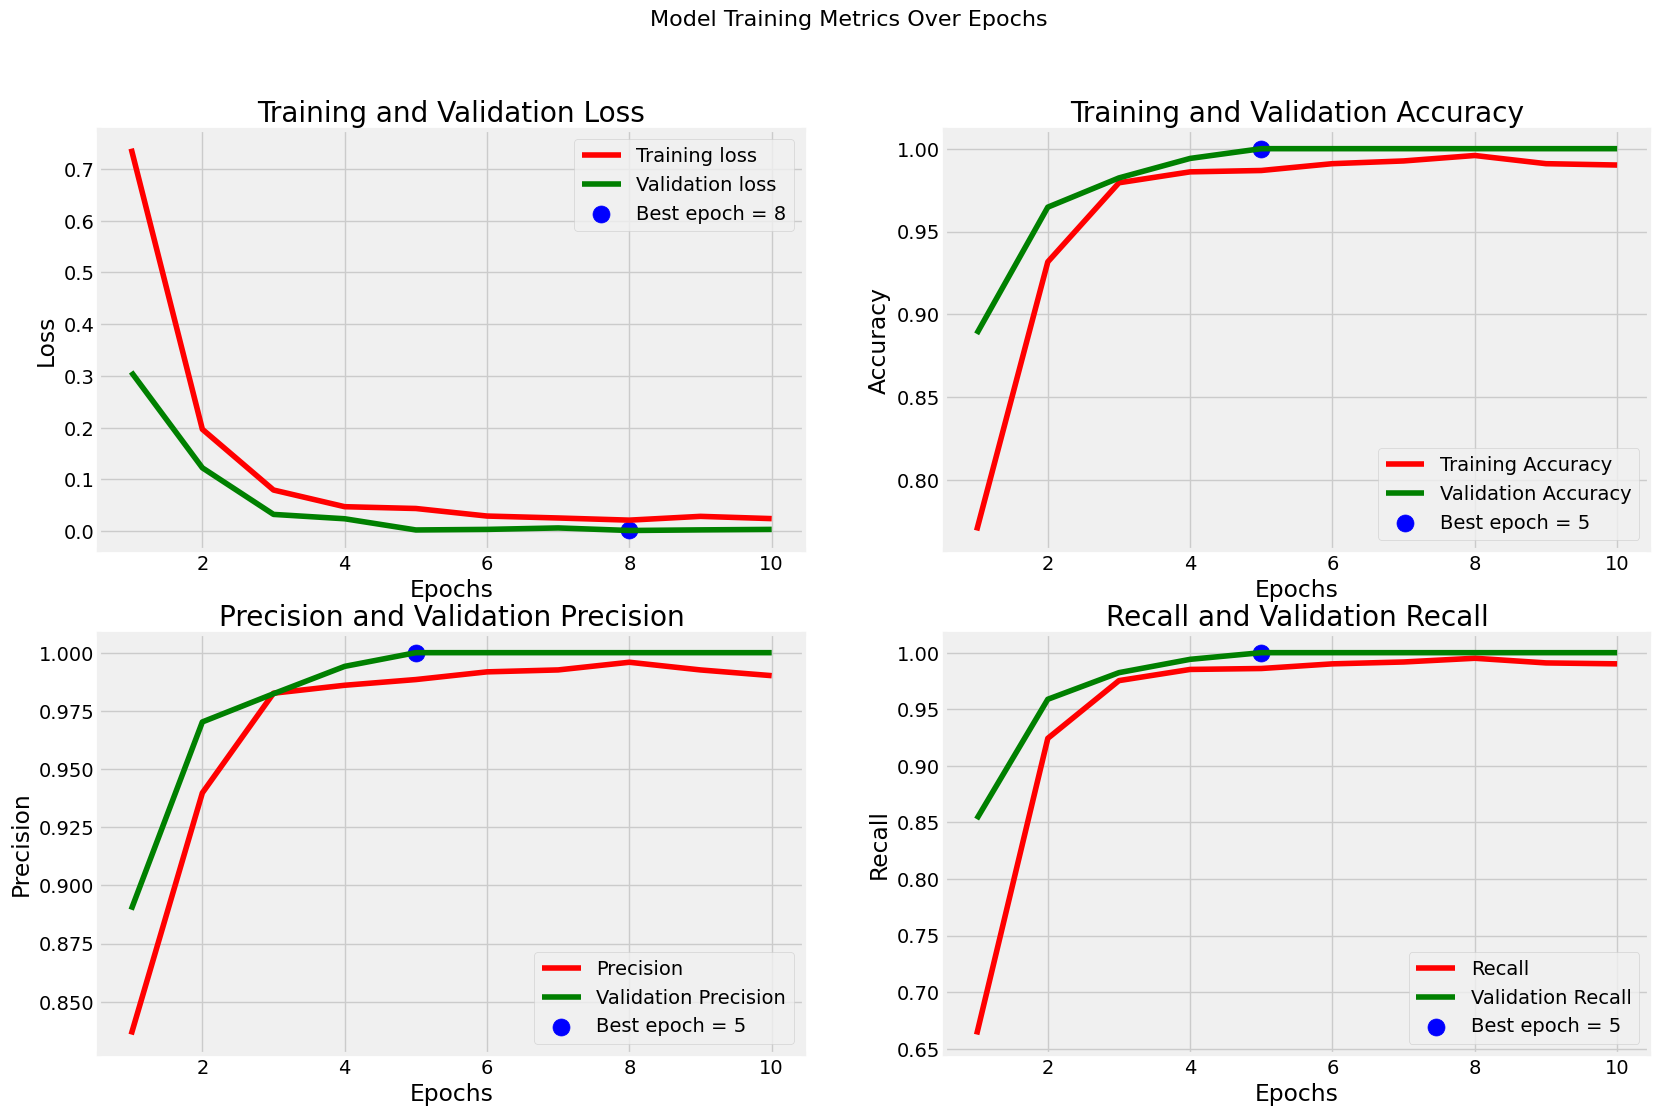

In [19]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [20]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 365ms/step - accuracy: 0.9969 - loss: 0.0126 - precision: 0.9969 - recall: 0.9969
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 1.0000 - loss: 0.0016 - precision: 1.0000 - recall: 1.0000   
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 1.0000 - loss: 0.0072 - precision: 1.0000 - recall: 1.0000
Train Loss: 0.0054
Train Accuracy: 99.84%
--------------------
Validation Loss: 0.0045
Validation Accuracy: 100.00%
--------------------
Test Loss: 0.0064
Test Accuracy: 100.00%


In [21]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 407ms/step


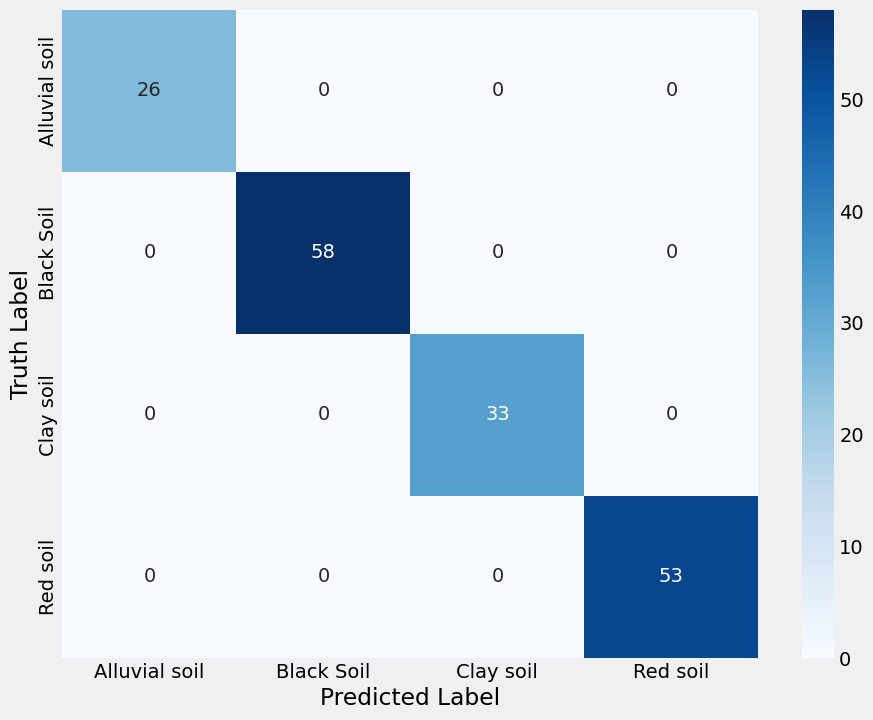

In [22]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [23]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00        53

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170



In [24]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


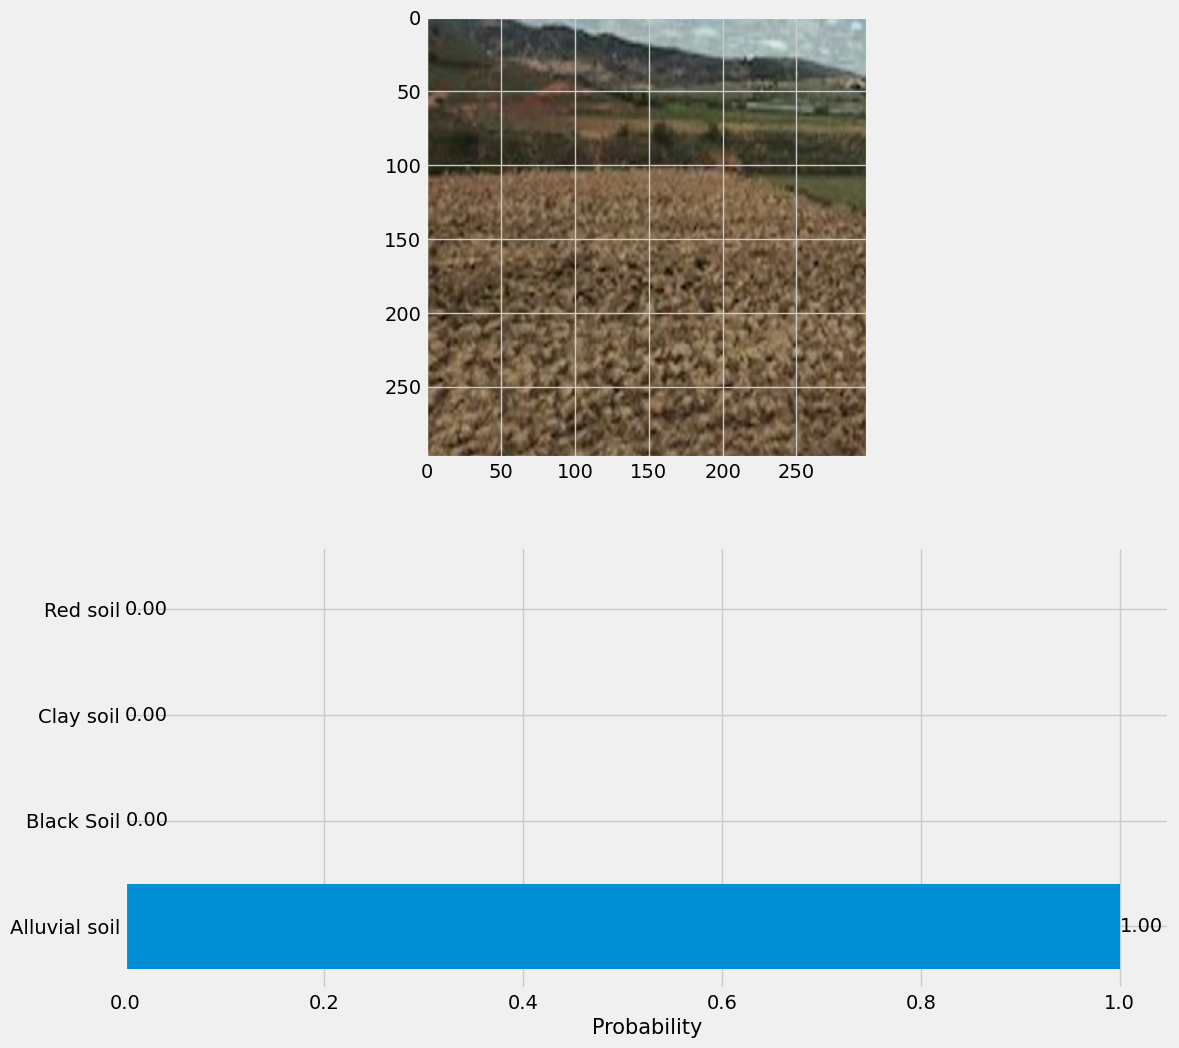

In [25]:
predict('/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_1.jpg')